<a href="https://colab.research.google.com/github/FrancescoSimoncelli/stock-prediction/blob/master/STOCK%20NEURAL%20GARCH%20COMB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [67]:
'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

In [68]:
data = pd.read_excel(r'./drive/My Drive/Colab Notebooks/MHK US Equity.xlsx')
date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
data.head()

,DATA,PX_LAST,PX_ASK,PX_BID,NET_INCOME_MARGIN_ADJUSTED,WACC_COST_DEBT,BS_ST_BORROW,BS_LT_BORROW,IS_RD_EXPEND,PX_TO_BOOK_RATIO,IS_INT_EXPENSE,CF_FREE_CASH_FLOW,QUICK_RATIO,CUR_RATIO,WACC,WACC_COST_DEBT.1,WACC_COST_EQUITY,ROC_WACC_RATIO,BEST_NET_DEBT,NET_DEBT_TO_SHRHLDR_EQTY,NET_DEBT_%_CAPITAL,EBITDA,EBIT,BEST_NET_INCOME,EBITDA_TO_REVENUE,EBIT_TO_NET_SALES,BS_TOT_ASSET,SALES_REV_TURN,BEST_EST_PE_CUR_YR,BEST_PE_RATIO,CURR_ENTP_VAL,REVENUE_GROWTH_ADJUSTED_5Y_CAGR,SALES_GROWTH,EBITDA_GROWTH,GEO_GROW_EBITDA,NET_INC_GROWTH,GEO_GROW_NET_INC,BEST_EPS_NXT_YR,MOV_AVG_50D,MOV_AVG_200D,RSI_14D,RSI_30D,RSI_9D,PX_VOLUME
0,2013-12-31,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
1,2014-01-01,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
2,2014-01-02,149.11,149.10,149.07,7.0948,3.3894,127.218,2132.79,0,2.4295,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13044.2809,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.3660,123.4603,65.4500,65.3393,68.4927,676997
3,2014-01-03,149.45,149.48,149.47,7.0948,3.3894,127.218,2132.79,0,2.4351,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13068.9733,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.8022,123.6346,65.9809,65.5808,69.3643,521291
4,2014-01-06,147.34,147.40,147.36,7.0948,3.3894,127.218,2132.79,0,2.4007,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,12915.7349,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,140.1838,123.8148,59.8358,62.7730,58.1367,470527


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [70]:
pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp36-none-any.whl size=8423 sha256=b50d8db92edb6750ca2397bd570e7db938447fa8f16e4c47027d2b09518aa55a
  Stored in directory: /tmp/pip-ephem-wheel-cache-99g2q0e7/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [0]:
data['log_price'] = np.log(data['PX_LAST']) #take the logarithmic return from prices

In [0]:
data['pct_change'] = data['log_price'].diff() #after that let's take difference

In [0]:
data['stdev'] = data['pct_change'].rolling(window=30, center=False).std()
data['Volatility'] = data['stdev'] * (252**0.5) # Annualize.

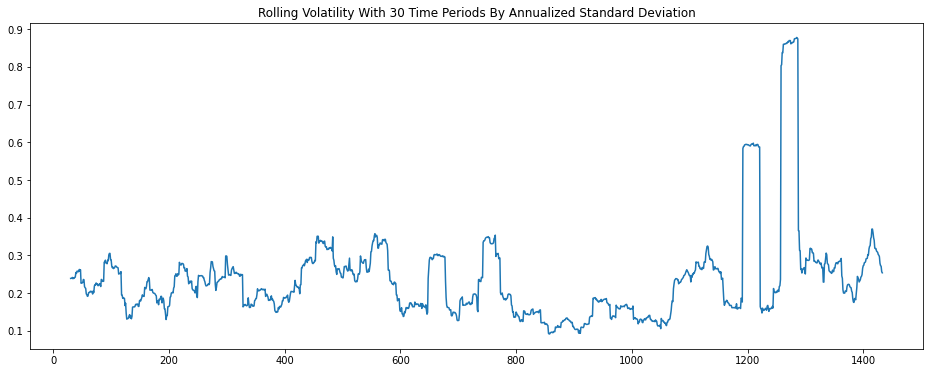

In [75]:
plt.figure(figsize=(16,6))
data['Volatility'].plot()
plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
plt.show()

In [0]:
data = data.dropna()
vol = data["Volatility"] * 100

In [77]:
from arch import arch_model
am = arch_model(vol, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                      -0.093
Mean Model:             Constant Mean   Adj. R-squared:                 -0.093
Vol Model:                      GARCH   Log-Likelihood:               -4512.41
Distribution:                  Normal   AIC:                           9032.83
Method:            Maximum Likelihood   BIC:                           9053.82
                                        No. Observations:                 1404
Date:                Mon, May 25 2020   Df Residuals:                     1400
Time:                        13:29:24   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            19.8706      2.707      7.339  2.145e-13 [ 14.564, 25.177]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.8873     24.421      0.118      0.906 [-44.978, 50.752]
alpha[1]       1.0000      1.861      0.537      0.591 [ -2.647,  4.647]
beta[1]    2.2759e-14  7.692e-02  2.959e-13      1.000 [ -0.151,  0.151]
========================================================================

Covariance estimator: robust
"""

In [78]:
#After fitting the GARCH(1,1) model, by the formula above, it is possible to forecast rolling volatility.
#The last 10 rows of the final form of the data.
data['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + 
                                   res.conditional_volatility**2 * res.params['beta[1]'])
display(data.tail(10))

,DATA,PX_LAST,PX_ASK,PX_BID,NET_INCOME_MARGIN_ADJUSTED,WACC_COST_DEBT,BS_ST_BORROW,BS_LT_BORROW,IS_RD_EXPEND,PX_TO_BOOK_RATIO,IS_INT_EXPENSE,CF_FREE_CASH_FLOW,QUICK_RATIO,CUR_RATIO,WACC,WACC_COST_DEBT.1,WACC_COST_EQUITY,ROC_WACC_RATIO,BEST_NET_DEBT,NET_DEBT_TO_SHRHLDR_EQTY,NET_DEBT_%_CAPITAL,EBITDA,EBIT,BEST_NET_INCOME,EBITDA_TO_REVENUE,EBIT_TO_NET_SALES,BS_TOT_ASSET,SALES_REV_TURN,BEST_EST_PE_CUR_YR,BEST_PE_RATIO,CURR_ENTP_VAL,REVENUE_GROWTH_ADJUSTED_5Y_CAGR,SALES_GROWTH,EBITDA_GROWTH,GEO_GROW_EBITDA,NET_INC_GROWTH,GEO_GROW_NET_INC,BEST_EPS_NXT_YR,MOV_AVG_50D,MOV_AVG_200D,RSI_14D,RSI_30D,RSI_9D,PX_VOLUME,log_price,pct_change,stdev,Volatility,forecast_vol
1424,2019-06-17,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.019531,0.310040,1.126237
1425,2019-06-18,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.019416,0.308227,1.108319
1426,2019-06-19,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.019054,0.302478,1.051541
1427,2019-06-20,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.018935,0.300589,1.032903
1428,2019-06-21,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.018702,0.296890,0.996436
1429,2019-06-24,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.017588,0.279202,0.822702
1430,2019-06-25,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.017200,0.273045,0.762570
1431,2019-06-26,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.017092,0.271327,0.745830
1432,2019-06-27,145.1,175.72,128.0,7.39,2.2349,1862.974,1725.57,0,1.388,10.473,33.189,0.5097,1.3654,7.6117,2.2349,9.7236,0.9481,2826,45.9662,31.491,302.621,165.33,210.769,12.3899,6.7689,13605.075,2442.49,13.561,13.223,13997.4395,6.1408,1.2556,-22.6138,7.4058,-41.7602,8.4407,11.989,133.8564,141.2188,59.8664,57.3295,61.5338,36,4.977423,0.0,0.016176,0.256782,0.605109
1433,2019-06-28,145.1,175.72,128.

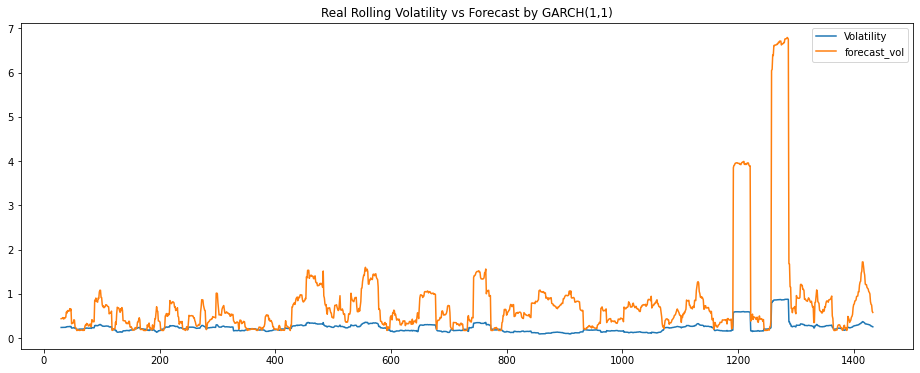

In [79]:
plt.figure(figsize=(16,6))
data["Volatility"].plot()
data["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(1,1)")
plt.legend()
plt.show()

In [85]:
#In order to measure the performance of the model, 
#Root Mean Squared Error is used and the output of this measure for the last 1000 observations is shown below. 
def rmse_tr(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
skor = rmse_tr(data.loc[data.index[350:], 'forecast_vol'], data.loc[data.index[350:], 'Volatility'])
print("Root Mean Squared Error of the model is calculated as ",skor)

Root Mean Squared Error of the model is calculated as  1.2442228923354677


LST: Firstly it is necessary to forecast volatility by the real rolling volatilities to be able to measure the performance two different models alone.

In [0]:
training_set = data.iloc[:, 47:48].values

X_train = []
y_train = []
for i in range(350, data.shape[0]):
    X_train.append(training_set[i-350:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [87]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1054/1054 [==============================] - 23s 21ms/step - loss: 0.0337
Epoch 2/100
1054/1054 [==============================] - 22s 20ms/step - loss: 0.0166
Epoch 3/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0132
Epoch 4/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0111
Epoch 5/100
1054/1054 [==============================] - 23s 21ms/step - loss: 0.0095
Epoch 6/100
1054/1054 [==============================] - 22s 21ms/step - loss: 0.0078
Epoch 7/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0074
Epoch 8/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0072
Epoch 9/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0076
Epoch 10/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0074
Epoch 11/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0065
Epoch 12/100
1054/1054 [============================

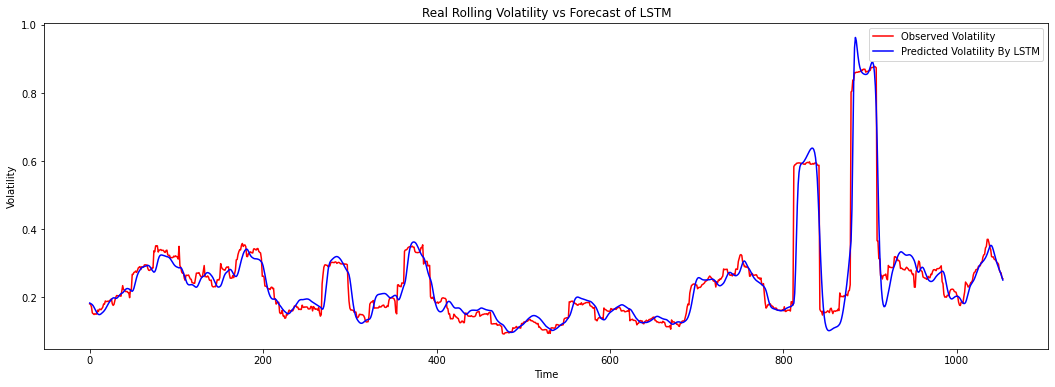

In [91]:
regressor.save('my_modelp1.h5')
from keras.models import load_model
regressor = load_model('my_modelp1.h5')
predicted_stock_price = regressor.predict(X_train)
# Visualising the results
plt.figure(figsize=(18,6))
plt.plot(data.iloc[350:, 47:48].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM')
plt.title('Real Rolling Volatility vs Forecast of LSTM')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [92]:
skor2 = rmse_tr(predicted_stock_price, np.array(data.loc[data.index[350:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ",skor2)

Root Mean Squared Error of the model is calculated as  0.1973213901114825


Neural-Garch Model (Combining Garch(1,1) and LSTM)


In [95]:
training_set = data.iloc[:, 47:49].values

X_train = []
y_train = []
for i in range(350, data.shape[0]):
    X_train.append(training_set[i-350:i,:])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 2)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1054/1054 [==============================] - 21s 20ms/step - loss: 0.0401
Epoch 2/100
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0222
Epoch 3/100
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0166
Epoch 4/100
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0137
Epoch 5/100
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0113
Epoch 6/100
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0106
Epoch 7/100
1054/1054 [==============================] - 20s 19ms/step - loss: 0.0091
Epoch 8/100
1054/1054 [==============================] - 20s 19ms/step - loss: 0.0086
Epoch 9/100
1054/1054 [==============================] - 20s 19ms/step - loss: 0.0072
Epoch 10/100
1054/1054 [==============================] - 19s 18ms/step - loss: 0.0071
Epoch 11/100
1054/1054 [==============================] - 20s 19ms/step - loss: 0.0071
Epoch 12/100
1054/1054 [============================

In [0]:
regressor.save('my_modelp2.h5')
from keras.models import load_model
regressor = load_model('my_modelp2.h5')
predicted_stock_price = regressor.predict(X_train)

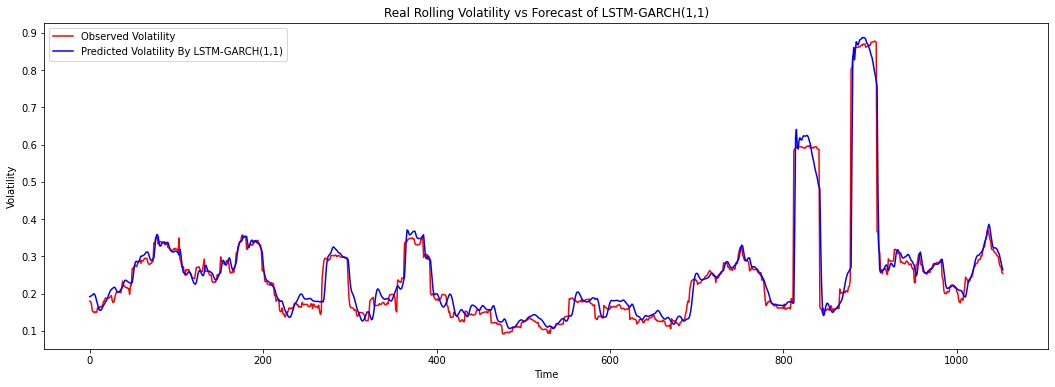

In [99]:
# Visualising the results
plt.figure(figsize=(18,6))
plt.plot(data.iloc[350:, 47:48].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM-GARCH(1,1)')
plt.title('Real Rolling Volatility vs Forecast of LSTM-GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [102]:
skor3 = rmse_tr(predicted_stock_price, np.array(data.loc[data.index[350:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ",skor3)

Root Mean Squared Error of the model is calculated as  0.19653716410841476
